<a href="https://colab.research.google.com/github/nur1hsan/Rotation-Curve-Fitting-with-MCMC-Method/blob/main/Fitting_NFW_Galaksi_Bulge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import beberapa library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Membuka data galaksi NGC5985
df = pd.read_excel("NGC5985.xlsx")

# Mendefinisikan beberapa parameter yang diperlukan
x = df["Galactocentric radius"]
y = df["Observed circular velocity"]
yerr = df["Uncertainty in Vobs (1)"]
Vdisk = df["Disk velocity contribution (3)"]
Vbulge = df["Bulge velocity contribution (3)"]
Vgas = df["Gas velocity contribution (2)"]

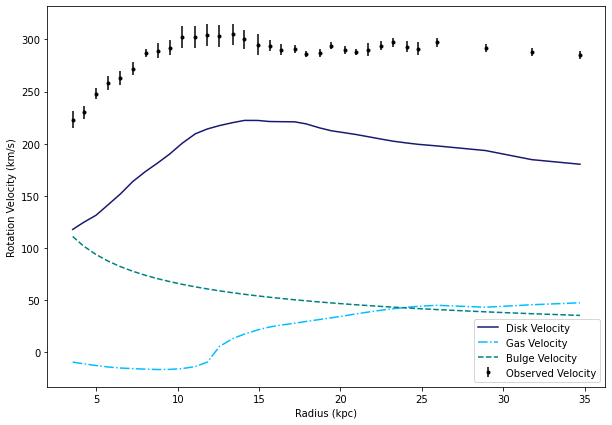

In [ ]:
# Membuat plot berdasarkan data
plt.figure(figsize=(10,7))
plt.errorbar(x, y, yerr=yerr, label="Observed Velocity", fmt=".k", capsize=0)
plt.plot(x, Vdisk, label="Disk Velocity", c="midnightblue")
plt.plot(x, Vgas, label="Gas Velocity", ls='dashdot', c="deepskyblue")
plt.plot(x, Vbulge, label="Bulge Velocity", ls='--', c="teal")
plt.legend(loc="lower right")
plt.xlabel("Radius (kpc)")
plt.ylabel("Rotation Velocity (km/s)")
plt.show()

In [ ]:
def log_likelihood(theta, x, y, Vdisk, Vgas, Vbulge, yerr):
    V200, C200, A, B, log_f = theta
    rs = V200/(10*C200*0.073)
    z = x/rs
    Vdm = V200*(((C200/z)*(((np.log(1+z))-(z/(1+z)))/((np.log(1+C200))-(C200/(1+C200)))))**0.5)
    model = ((Vdm**2) + (A*(Vdisk**2)) + (B*(Vbulge**2)) + (Vgas**2))**0.5
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [ ]:
def log_prior(theta):
    V200, C200, A, B, log_f = theta
    if 10.0 < V200 < 500.0 and 0.0 < C200 < 1000.0 and 0 < A < 10.0 and 0 < B < 10.0 and -5.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [ ]:
def log_probability(theta, x, y, Vdisk, Vgas, Vbulge, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, Vdisk, Vgas, Vbulge, yerr)

In [ ]:
import emcee

pos = [171, 29, 0.2, 0.2, np.log(0.01)] + 1e-7 * np.random.randn(50, 5)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, Vdisk, Vgas, Vbulge, yerr)
)
sampler.run_mcmc(pos, 10000, progress=True);

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:39<00:00, 14.30it/s]


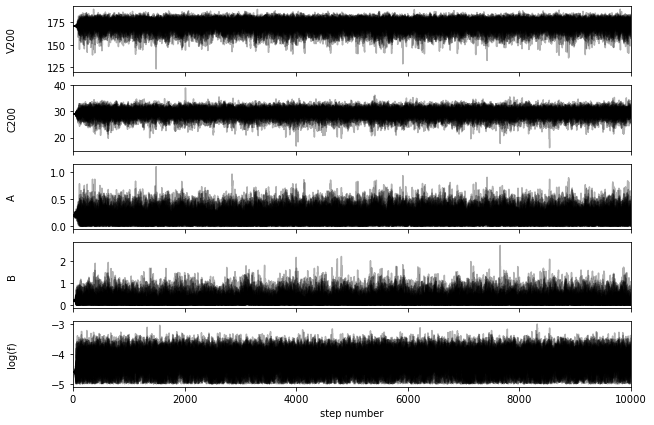

In [ ]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["V200", "C200", "A", "B", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(33000, 5)


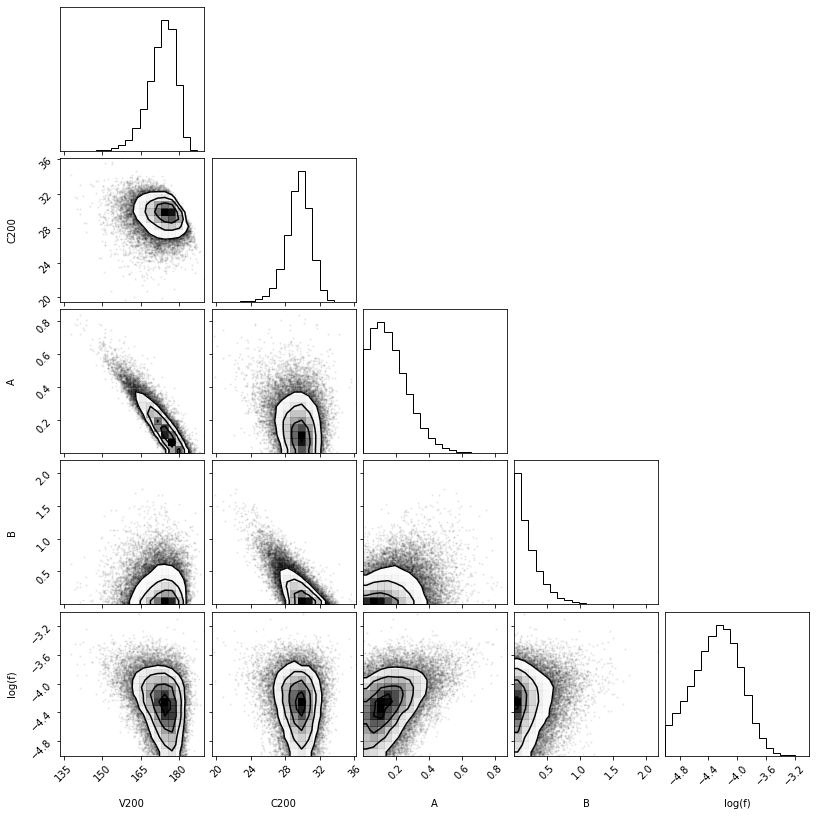

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=labels
);

In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
# Fungsi untuk fitting data
def f(x, V200, C200, A, B, Vdisk, Vgas, Vbulge):
    rs = V200/(10*C200*0.073)
    z = x/rs
    Vdm = V200*(((C200/z)*(((np.log(1+z))-(z/(1+z)))/((np.log(1+C200))-(C200/(1+C200)))))**0.5)
    model = ((Vdm**2) + (A*(Vdisk**2)) + (B*(Vbulge**2)) + (Vgas**2))**0.5
    return model

In [ ]:
# Fungsi untuk mengukur kecepatan komponen dark matter
def g(x, V200, C200):
    rs = V200/(10*C200*0.073)
    z = x/rs
    Vdm = V200*(((C200/z)*(((np.log(1+z))-(z/(1+z)))/((np.log(1+C200))-(C200/(1+C200)))))**0.5)
    return Vdm

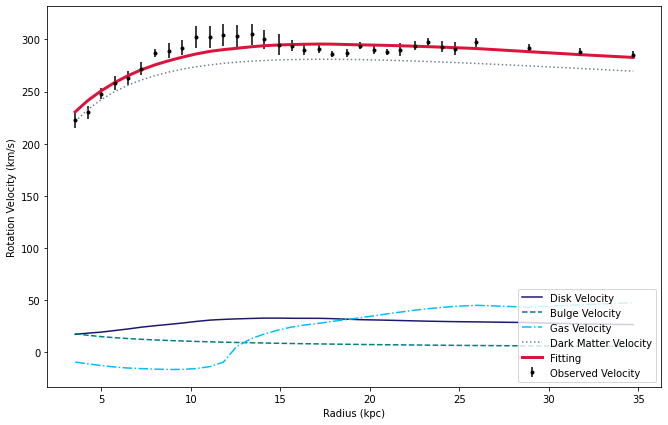

In [ ]:
# Membuat plot fitting kurva rotasi
plt.figure(figsize=(11,7))
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label="Observed Velocity")
plt.plot(x, Vdisk*0.148, label="Disk Velocity", c="midnightblue")
plt.plot(x, Vbulge*0.162, label="Bulge Velocity", ls='--', c="teal")
plt.plot(x, Vgas, label="Gas Velocity", ls='dashdot', c="deepskyblue")
plt.plot(x, g(x, 173.908, 29.605) , label="Dark Matter Velocity", ls='dotted', c="slategray")
plt.plot(x, f(x, 173.908, 29.605, 0.148, 0.162, Vdisk, Vgas, Vbulge), label="Fitting", c="crimson", linewidth=3.0)
plt.legend(loc="lower right")
plt.xlabel("Radius (kpc)")
plt.ylabel("Rotation Velocity (km/s)")
plt.show()

In [ ]:
# Menghitung kontribusi massa masing-masing komponen dalam persen
for i in range (len(df)):
    if i == (len(df)-1):
        disk = (((Vdisk[i]**2)*0.148)/(f(x[i], 173.908, 29.605, 0.148, 0.162, Vdisk[i], Vgas[i], Vbulge[i])**2))*100
        bulge = ((Vbulge[i]**2)*0.162/(f(x[i], 173.908, 29.605, 0.148, 0.162, Vdisk[i], Vgas[i], Vbulge[i])**2))*100 
        gas = ((Vgas[i]/f(x[i], 173.908, 29.605, 0.148, 0.162, Vdisk[i], Vgas[i], Vbulge[i]))**2)*100
        DM = ((g(x[i], 173.908, 29.605)/f(x[i], 173.908, 29.605, 0.148, 0.162, Vdisk[i], Vgas[i], Vbulge[i]))**2)*100
        print("Disk:", disk, "Bulge:", bulge, "Gas:", gas, "DM:", DM)

Disk: 6.024659711573834 Bulge: 0.2556836956289649 Gas: 2.8323895188429 DM: 90.88726707395429
